# 4.1. Modelo: Clasificador BERT

Se busca predecir la rama del arbol de categorias(familia, categoria y sub-categoria) en la que se encuentra un producto dado.

### Enlaces

- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Tutorial: Fine tuning BERT for Sentiment Analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
import transformers
from   torch import nn
from   torch.optim import Adam
    
import logging

from data.fashion import load_datasets
import data  as dt
import model as ml

import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-11-12 16:15:28,084 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
label_by_class = lambda df: {row['branch_seq']: row['branch'] for _, row in df[['branch_seq', 'branch']].drop_duplicates().iterrows() }

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
ut.set_seed(42)

Definimos el modelo preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
# MODEL_NAME ='bert-base-cased'
MODEL_NAME ='bert-base-uncased'
# MODEL_NAME = 'bert-large-uncased'
# MODEL_NAME ='distilbert-base-uncased'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
CACHE_PATH         = '../../cache'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/{MODEL_NAME}.h5'

In [12]:
TRAIN = False

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set, val_set, test_set = load_datasets(DATASET_PATH, prefix='bert_')

Tamaño máximo de la secuencia de entrada:

In [15]:
tokens_count = 2 + train_set['tokens_count'].max()
tokens_count

37

Definimos el tokenizer y los dataset para tran, validation y test:

In [16]:
tokenizer = ml.Tokenizer(
    tokenizer  = transformers.BertTokenizer.from_pretrained(MODEL_NAME), 
    padding    = 'max_length',
    max_length = tokens_count
)

In [17]:
train_dataset = dt.Dataset(train_set, feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.Dataset(val_set,   feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.Dataset(test_set,  feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [18]:
len(train_set['branch_seq'].unique())

133

In [19]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

133

In [20]:
classifier = ml.Classifier(
    transformer     = transformers.BertModel.from_pretrained(
        MODEL_NAME, 
        use_cache = True, 
        cache_dir = CACHE_PATH
    ),
    output_dim      = n_classes,
    dropout         = 0,
    hiden_state_dim = 768
)

## Entrenamiento

In [21]:
if TRAIN:
    model = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())

In [22]:
if TRAIN:
    LR     = 0.00001
    EPOCHS = 6

    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

In [23]:
if TRAIN:
    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [24]:
classifier.load(MODEL_WEIGHTS_PATH)

In [25]:
model   = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())
summary = model.validate(test_dataset)
summary.show()

Accuracy: 81.62%, Loss: 0.016844


Guardamos target y predicciones:

In [26]:
label_by_class_dict = label_by_class(test_set)

pd.DataFrame({
    'predictions': [label_by_class_dict[e] for e in np.concatenate(summary.predictions)],
    'target'     : [label_by_class_dict[e] for e in np.concatenate(summary.targets)]
}).to_csv(f'{DATASET_PATH}/bert-pred-target.csv', index=False)

In [26]:
np.array(summary.targets).shape

(2782,)

                                                      precision    recall  f1-score   support

                               accessories~belts~n/d       0.98      0.97      0.97       146
                                accessories~hats~n/d       0.94      1.00      0.97       254
                             accessories~scarves~n/d       0.97      0.98      0.98      2000
                          accessories~sunglasses~n/d       1.00      1.00      1.00       186
             activewear~performance tops~sports bras       0.79      0.94      0.86       126
activewear~performance trousers~performance leggings       0.84      0.58      0.69       158
                      activewear~skiwear~ski jackets       0.71      0.47      0.57        78
                                  bags~backpacks~n/d       0.99      0.98      0.98       827
                                  bags~belt bags~n/d       0.83      0.96      0.89       386
                                bags~bucket bags~n/d       

<Figure size 2500x2500 with 2 Axes>

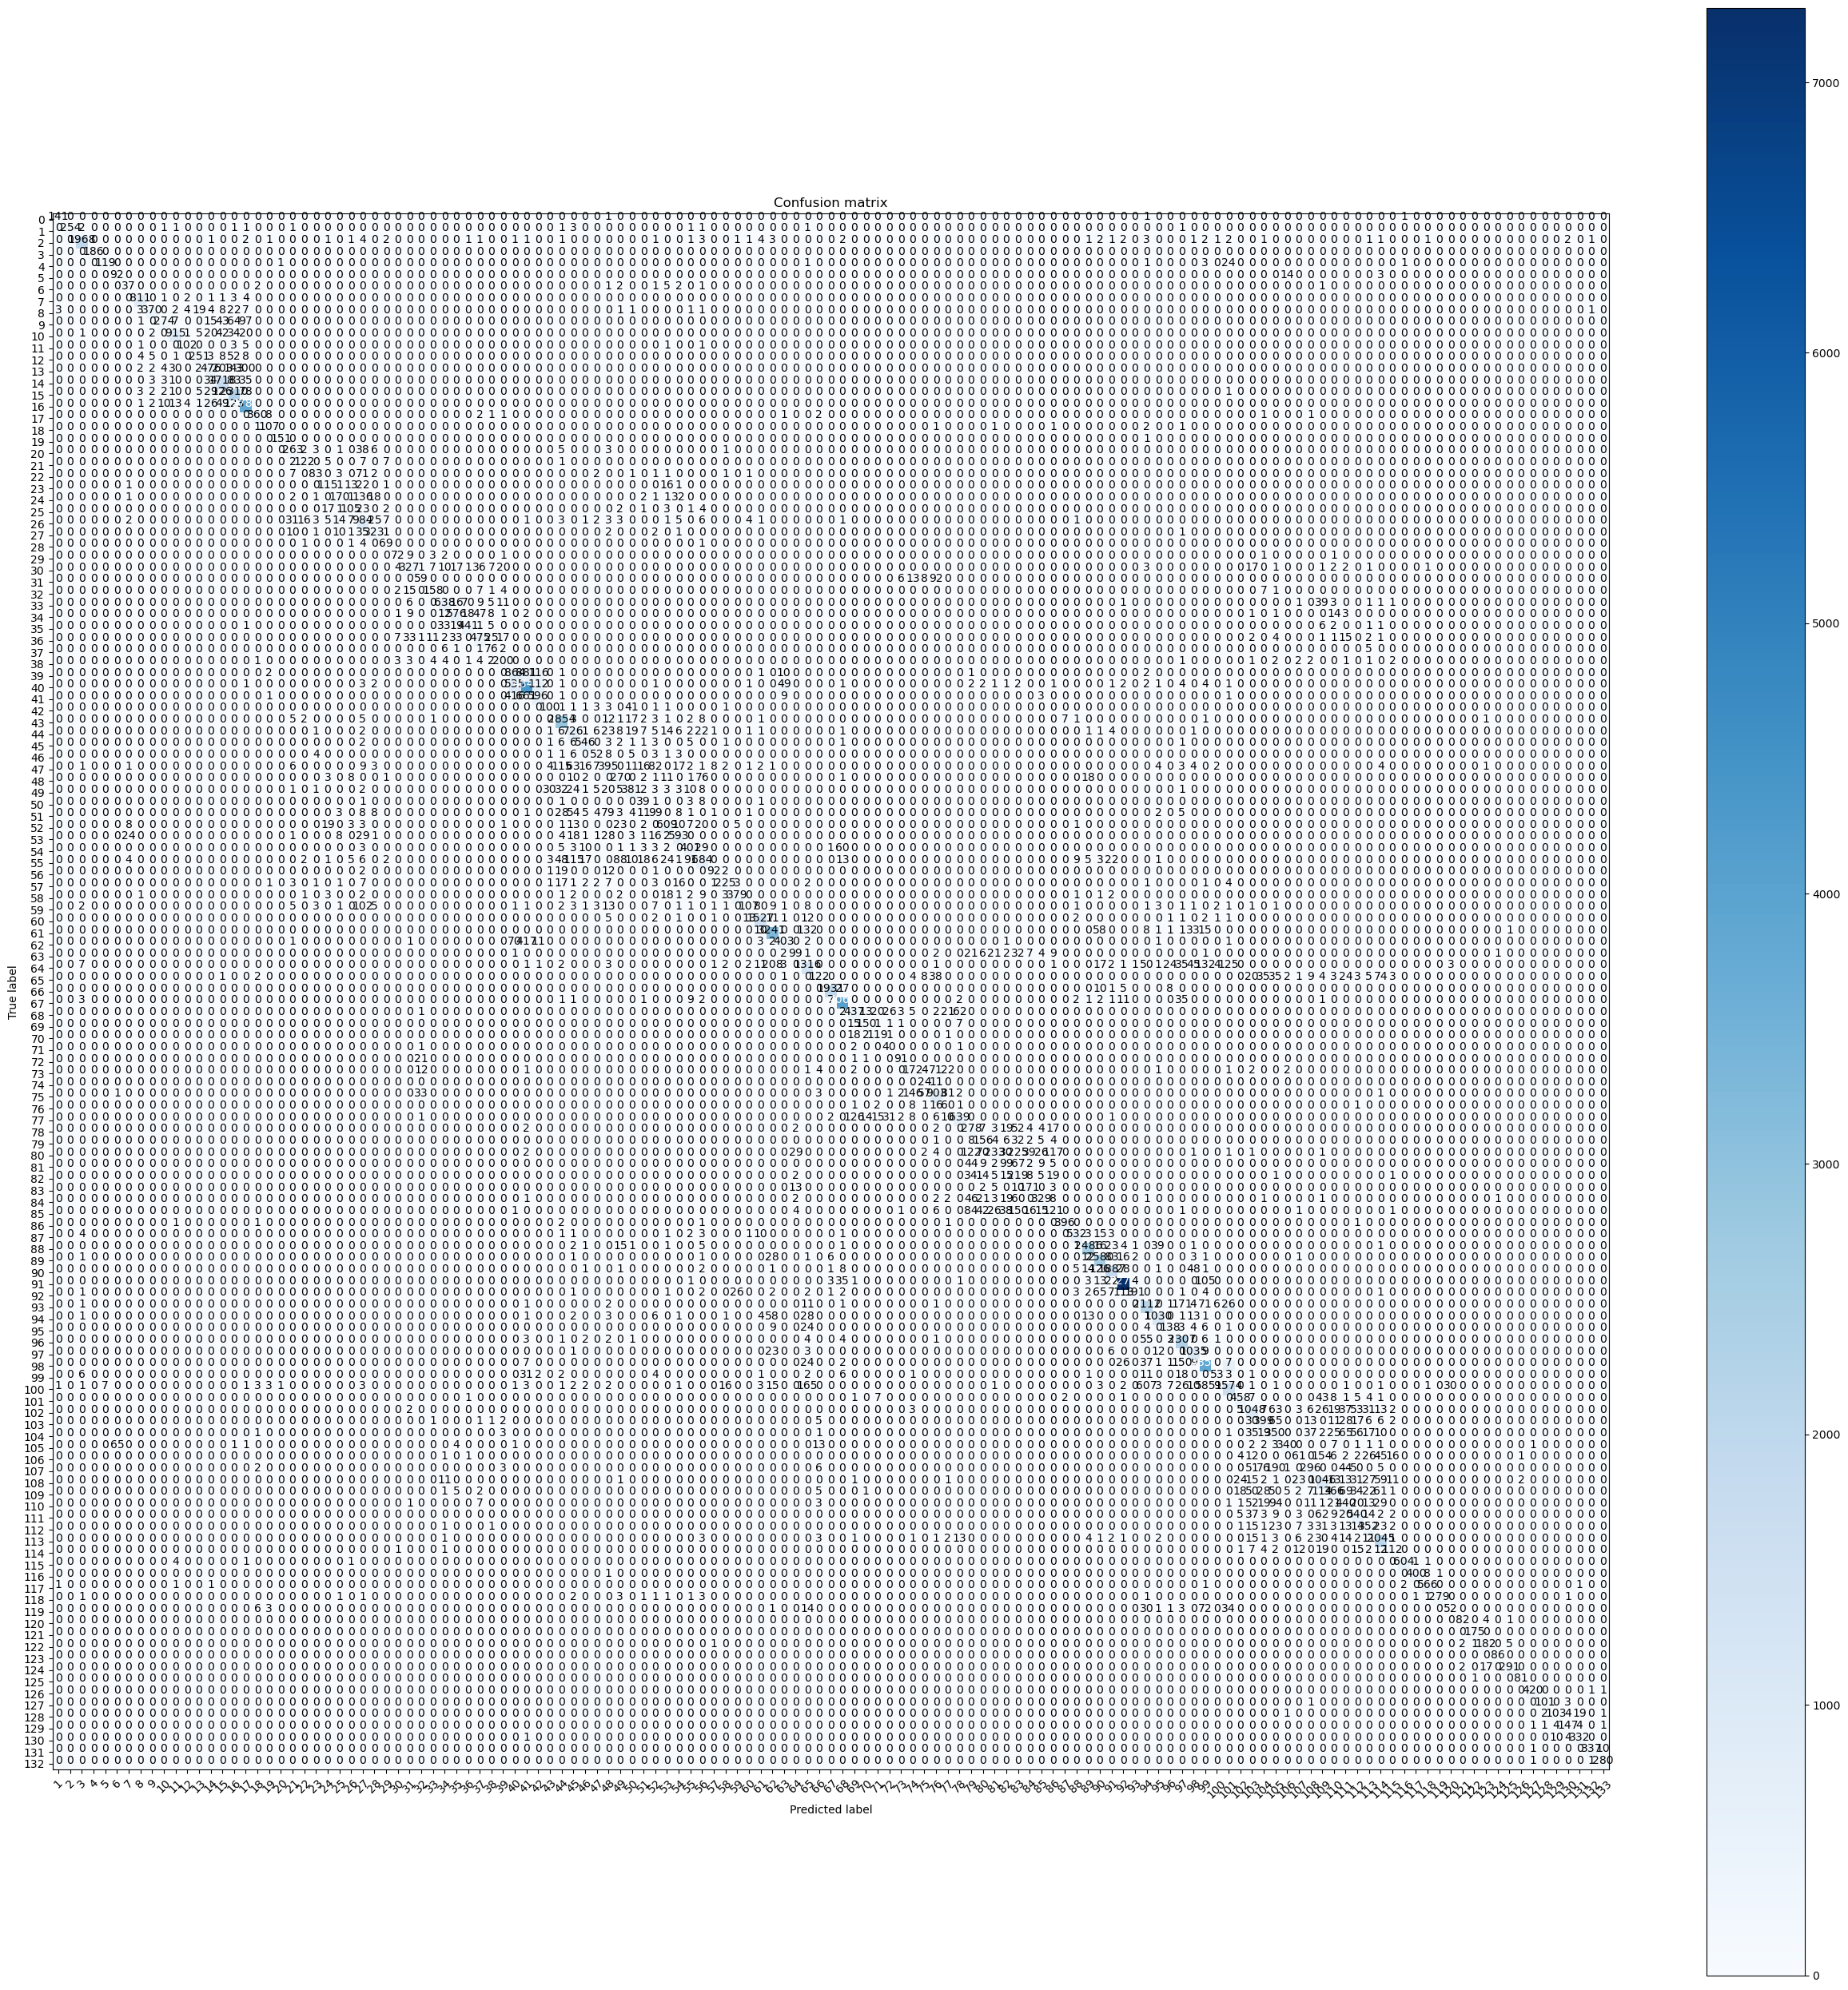

In [27]:
summary.plot_metrics(label_by_class = label_by_class(train_set))

In [28]:
report_generator = ml.FailReportGenerator(
    tokenizer, 
    test_set, 
    test_dataset, 
    summary.targets, 
    summary.predictions,
    IMAGES_PATH
)

report = report_generator()

report.to_csv(f'{DATASET_PATH}/bert-model-fail-report.csv', index=False)

Total Fails: 18.07%


Determinamos cuales son las clases con bajo **f1-score**:

In [29]:
less_than_f1_score = 0.5
    
worst_classes = summary.predicted_classes_by(
    less_than_f1_score = less_than_f1_score,
    label_by_class     = label_by_class(train_set)
)
worst_classes

report1 = report[report.true_class.isin(worst_classes)]
report1.to_csv(f'{DATASET_PATH}/f1_score_lt_{less_than_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((3503, 5), (111253, 14))

In [30]:
ut.display_html(report1.sample(frac=1).head(7))

,description,true_class,true_image,pred_class,pred_image
18003,description : monogram jacquard trousers. gender : women. brand : koche. materials : cotton polyester ovine leather ( top grain ).,clothing~trousers~high-waisted trousers,,clothing~trousers~slim-fit trousers,
1826,description : beaded - collar maxi dress. gender : women. brand : antonelli. materials : polyamide silk acetate.,clothing~dresses~cocktail & party dresses,,clothing~dresses~evening dresses,
12203,description : high - waisted box - pleat skirt. gender : women. brand : aspesi. materials : cotton.,clothing~skirts~high-waisted skirts,,clothing~skirts~pleated skirts,
15877,description : wide leg trousers. gender : women. brand : alberta ferretti. materials : viscose.,clothing~trousers~high-waisted trousers,,clothing~trousers~palazzo pants,
2432,description : mid - length sleeveless dress. gender : women. brand : nº21. materials : viscose spandex / elastane.,clothing~dresses~cocktail & party dresses,,clothing~dresses~day dresses,
11996,description : monogram print midi dress. gender : women. brand : rokh. materials : cotton.,clothing~dresses~cocktail & party dresses,,clothing~dresses~day dresses,
16168,description : zebra - print silk mini dress. gender : women. brand : isabel sanchis. materials : silk viscose.,clothing~dresses~evening dresses,,clothing~dresses~cocktail & party dresses,


In [31]:
less_than_f1_score = 0.27

worst_classes = summary.predicted_classes_by(
    less_than_f1_score = less_than_f1_score,
    label_by_class     = label_by_class(train_set)
)
worst_classes

report1 = report[report.true_class.isin(worst_classes)]
report1.to_csv(f'{DATASET_PATH}/f1_score_lt_{less_than_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((62, 5), (111253, 14))

In [32]:
ut.display_html(report1.sample(frac=1).head(7))

,description,true_class,true_image,pred_class,pred_image
13710,description : pleat - detail trousers. gender : men. brand : mouty. materials : viscose polyester.,clothing~trousers~loose fit,,clothing~trousers~regular & straight-leg trousers,
15227,description : colour - block trousers. gender : men. brand : kenzo. materials : polyamide.,clothing~trousers~loose fit,,clothing~trousers~regular & straight-leg trousers,
13029,description : corduroy wide - leg trousers. gender : men. brand : marni. materials : cotton.,clothing~trousers~loose fit,,clothing~trousers~wide-leg trousers,
9048,description : antico taffeta trousers. gender : men. brand : the row ( vip ). materials : polyester.,clothing~trousers~loose fit,,clothing~trousers~regular & straight-leg trousers,
9013,description : gabardine 3tuck wide pants. gender : men. brand : yohji yamamoto. materials : cupro wool.,clothing~trousers~loose fit,,clothing~trousers~wide-leg trousers,
13230,description : jacquard label snuggy pant blu royal yel. gender : men. brand : opening ceremony. materials : polyester cotton.,clothing~trousers~loose fit,,clothing~sweaters & knitwear~jumpers,
12783,description : arm - applique straight - leg trousers. gender : men. brand : yohji yamamoto. materials : linen / flax.,clothing~trousers~loose fit,,clothing~trousers~regular & straight-leg trousers,


In [33]:
branch_by_seq = {r['branch_seq']: r['branch'] for _, r in train_set[['branch_seq', 'branch']].drop_duplicates().iterrows()}

branch_predictions = [branch_by_seq[e] for e in np.concatenate(summary.predictions)]
branch_targets     = [branch_by_seq[e] for e in np.concatenate(summary.targets)]

family_predictions = [e.split('~')[0] for e in branch_predictions]
family_targets     = [e.split('~')[0] for e in branch_targets]

category_predictions = [e.split('~')[1] for e in branch_predictions]
category_targets     = [e.split('~')[1] for e in branch_targets]

subcategory_predictions = [e.split('~')[2] for e in branch_predictions]
subcategory_targets     = [e.split('~')[2] for e in branch_targets]

                      precision    recall  f1-score   support

         accessories       0.97      0.99      0.98      2586
          activewear       0.80      0.69      0.74       362
                bags       1.00      1.00      1.00     12890
            clothing       1.00      1.00      1.00     90727
           jewellery       0.98      1.00      0.99      1869
lingerie & nightwear       0.24      0.61      0.34        85
           pre-owned       1.00      0.99      1.00       938
               shoes       1.00      1.00      1.00      1796

            accuracy                           1.00    111253
           macro avg       0.87      0.91      0.88    111253
        weighted avg       1.00      1.00      1.00    111253



<Figure size 400x400 with 2 Axes>

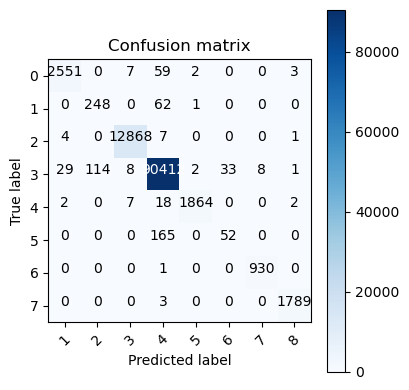

In [34]:
ml.plot_metrics(family_targets, family_predictions, figuresize=(4, 4))

In [ ]:
ml.plot_metrics(category_targets, category_predictions, figuresize=(15, 15))

                            precision    recall  f1-score   support

                all in one       0.97      0.94      0.96       505
                 backpacks       0.99      0.98      0.98       827
                 beachwear       0.99      0.99      0.99       153
                 belt bags       0.83      0.96      0.89       386
                     belts       0.98      0.97      0.97       146
                    bodies       0.24      0.61      0.34        85
                     boots       1.00      0.99      0.99       424
                 bracelets       0.99      0.99      0.99       608
               bucket bags       0.55      0.93      0.69       295
               clutch bags       0.88      0.92      0.90       995
                     coats       0.96      0.90      0.93      3199
                     denim       0.93      0.97      0.95      3730
                   dresses       0.99      0.94      0.96      9269
                  earrings       0.98      1.00

<Figure size 1500x1500 with 2 Axes>

In [ ]:
ml.plot_metrics(subcategory_targets, subcategory_predictions, figuresize=(24, 24))